<hr style="height:1px">
# WorkBook #3
## Building a Classification Model to predict the state of respondent's mental health using selected features
<hr style="height:1px">

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('notebook_repr_html',False)

In [2]:
# Read in the SAS format file into a pandas dataframe
df = pd.read_sas('LLCP2013.XPT')

In [3]:
# Use only completed survey records (433220 no of records)
df = df[df.DISPCODE == 1100.0]
df.shape

(433220, 336)

In [4]:
# Define the list of columns that will be included in the study and make a new dataframe 
# with only those out of all 336 columns

cname = ['_STATE', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'MEDCOST', 'SLEPTIM1', 
         'BPHIGH4', 'TOLDHI2', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 
         'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 
         'DIABETE3', 'MARITAL', 'EMPLOY1', 'CPDEMO1', 'SEX',
         'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON',
         '_RACE', '_AGE_G', '_BMI5CAT', '_EDUCAG', '_INCOMG', '_PACAT1', '_SMOKER3', '_RFBING5',
         '_RFDRHV4', '_FRUTSUM', '_VEGESUM']

data = pd.DataFrame() # New Dataframe with 41 variables 
for each in df.columns:
    if each in cname:
        data[each] = df[each]

In [5]:
#------------- Preliminary Processing of the Data
# 1) Remove all irrelevant answers (Not sure, Blank, Not Answered etc)
# 2) Categorize some continuous variables
# 3) Combine some columns into one variable

# Define function to remove less useful answers
def cleaner(dframe,variable,val1,val2):
    dframe = dframe[(dframe[variable] != val1) & (dframe[variable] != val2)]
    return dframe

for each in data[[1,4] + range(6,20) + [21] + range(23,30)]:
    data = cleaner(data,each,7.,9.)

for each in data[[2,3,5]]:
    data = cleaner(data,each,77,99)
    
data.PHYSHLTH[data.PHYSHLTH == 88] = 0 # Symbolize healthy days by 0
data.MENTHLTH[data.MENTHLTH == 88] = 0

for each in data[[20,30,33,34,35,36,37,40]]:
    data = cleaner(data,each,9.,9.)

In [6]:
# Convert number of sick/healthy days to categories

def valuetocat(bins,dframe,variable,newname):
    group_names = range(len(bins)-1)
    categories = pd.cut( dframe[variable], bins, labels = group_names )
    dframe[newname] = categories
    return dframe

# Choose 3 categories : 
#  0 (healthy:less than 5 days of sickness); 
#  1 (less healthy: between 5-15 days of sickness);
#  2 (unhealthy: more than 15 days of sickness)

bins = [-1.0, 5., 15., 32.]  # 3 categories
data = valuetocat(bins,data,'PHYSHLTH','phealthy')
data = valuetocat(bins,data,'MENTHLTH','mhealthy')

In [7]:
# Preparing the chronic disease column by combining all the chronic disease responses 
# Step#1 : Assign 1 for diseased and 0 otherwise 

for each in data[range(6,19)]:
    data = cleaner(data,each,7.,9.)
    data[each][data[each] == 4] = 1
    data[each][(data[each] == 2) | (data[each] == 3)] = 0 

# Step#2 : Extract all the chronic disease responses into a separate dataframe

chronic = pd.concat([data[range(6,16)],data[range(17,19)]], axis=1)  # Leave out Diagnosed mental illness cases 

# Step#3 : Define new variable 'chronic' which is sum of all the columns in chronic table - 
#       if chronic = 0 person is disease free else person has atleast one chronic disease

data['Chronic'] = chronic.sum(axis=1)

#  commented to keep this column continuous
# data.Chronic = np.where(data.Chronic == 0, 0, 1)    

/home/parama/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/parama/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# Combine all diseases impairing daily life - 
# Step#1 : Extract all impairments into a separate dataframe

impaired = data[range(23,30)]

# Step#2 : Assign 1 for diseased and 0 otherwise 

for each in impaired.columns : 
    impaired[each][impaired[each] == 2] = 0
    
# Step#3 : Define new variable 'impaired' which is sum of all the columns in impaired table - 
#       if impaired = 0 person is disease free else person has atleast one impairment

data['Impaired'] = impaired.sum(axis=1)   
# Commented for now to keep column continuous
#data.Impaired = np.where(data.Impaired == 0, 0, 1)

/home/parama/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/parama/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
# Convert total fruit and veg consumption into categories

bins = [0, 1, 50, 250, 20000]

data = valuetocat(bins,data,'_FRUTSUM','fruitdiet')
data = valuetocat(bins,data,'_VEGESUM','vegdiet')

In [10]:
# Store the processed dataframe into a text file for future use
data.to_csv('mental_health.csv')

In [135]:
# Start building a new dataframe which will include composite features

modeldata = pd.DataFrame()
modeldata = data[[0,1,2,3,4,5,16,19,20,21,22,30,31,32,33,34,35,36,37,38,39,40,43,44]].copy()

In [136]:
# Remove Nulls
modeldata = modeldata.dropna()
modeldata.shape

(225644, 24)

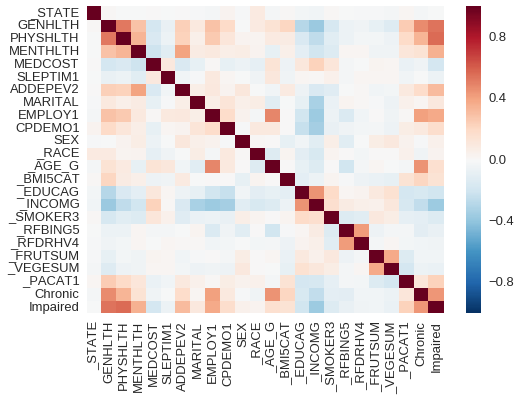

In [137]:
# Correlation of the selected features with each other:
# This correlation heat map needs cautious handling as some of the variables are categorical 
# while some are continuous - This was done just to get a general idea
sns.set(font_scale=1.3)
f1 = modeldata
r = f1.apply(lambda s: f1.corrwith(s))
sns.heatmap(r);

We will drop a few columns that show significant correlation with others (and can be logically related) before doing the model-fitting. 
- 1) 2 variables for indicating level of alcohol consumption may be reduced to one


- 2) Also the following are all somewhat correlated 
    - general health
    - physically healthy no of days
    - chronic disease
    - impairment

 We could choose just one/two of them - GenHealth, Chronic
 
    
- 3) Only retain fruit consumption and remove veg consumption


- 4) Education, employment, Income, age are also a close knit unit - but we keep all of them to start with.

In [64]:
y_input = modeldata.ADDEPEV2
modeldata.drop(['PHYSHLTH','_RFBING5','_FRUTSUM','Impaired','ADDEPEV2'],inplace=True,axis=1)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score

In [16]:
# Instantiating Logistic Regressor
logregr = LogisticRegression(class_weight = "balanced",C=1.)

In [17]:
# Instantiating Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=15)

In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def featureimpplot(X_train):
    importances = rfc.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfc.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],color="r",align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

def modelpipeline(fdata,out,model):
    X_train,X_test,y_train,y_test = train_test_split(fdata,out,test_size=0.33)
    if model == 1:
        logregr.fit(X_train,y_train)
        y_pred = logregr.predict(X_test)
        scores = cross_val_score(logregr, X_test, y_test, cv=10)
        print 'Performance of Logistic Regression : '
        print("Accuracy: %0.2f (+/- %0.2f)" %(scores.mean(), scores.std()*2))
        print 'Precision : ',precision_score(y_test, y_pred,pos_label = 1)  
        print 'Recall : ',recall_score(y_test,y_pred, pos_label = 1)
    elif model == 2:
        rfc.fit(X_train,y_train)
        y_pred = rfc.predict(X_test)
        scores = cross_val_score(rfc, X_test, y_test, cv=10)
        print 'Performance of Random Forest : '
        print("Accuracy: %0.2f (+/- %0.2f)" %(scores.mean(), scores.std()*2))
        print 'Precision : ',precision_score(y_test, y_pred,pos_label = 1)  
        print 'Recall : ',recall_score(y_test,y_pred, pos_label = 1)
        featureimpplot(X_train)
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm)

    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

    plt.show()

Performance of Logistic Regression : 
Accuracy: 0.77 (+/- 0.01)
Precision :  0.427962613202
Recall :  0.620968308622
Confusion matrix, without normalization
[[48420 11812]
 [ 5394  8837]]
Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.38  0.62]]


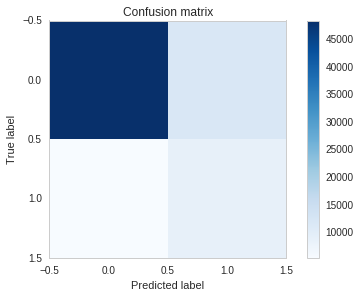

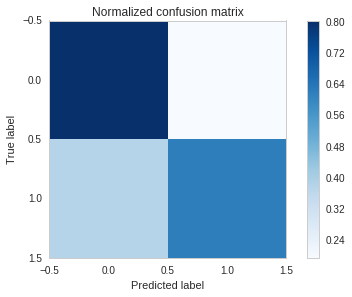

In [19]:
modelpipeline(modeldata,y_input,1)

Performance of Random Forest : 
Accuracy: 0.83 (+/- 0.01)
Precision :  0.615460607557
Recall :  0.342331204066


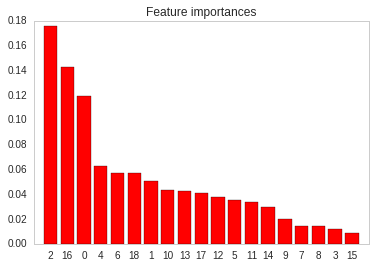

Confusion matrix, without normalization
[[56790  3114]
 [ 9575  4984]]
Normalized confusion matrix
[[ 0.95  0.05]
 [ 0.66  0.34]]


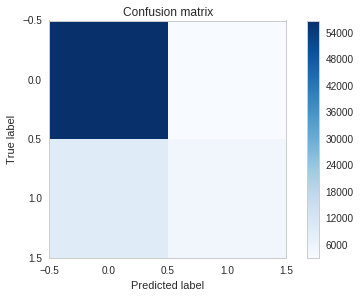

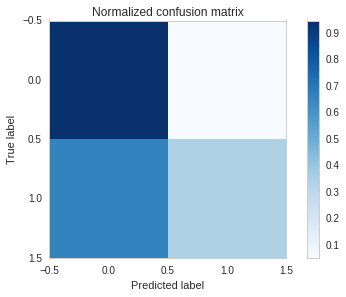

In [24]:
modelpipeline(modeldata,y_input,2)

In [65]:
# Remove menthlth variable to see importance of other features
store = modeldata
modeldata.drop(['MENTHLTH'],inplace=True,axis=1)

Performance of Logistic Regression : 
Accuracy: 0.68 (+/- 0.01)
Precision :  0.330835078438
Recall :  0.624176890552
Confusion matrix, without normalization
[[41822 18214]
 [ 5422  9005]]
Normalized confusion matrix
[[ 0.7   0.3 ]
 [ 0.38  0.62]]


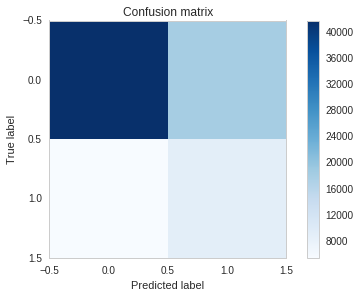

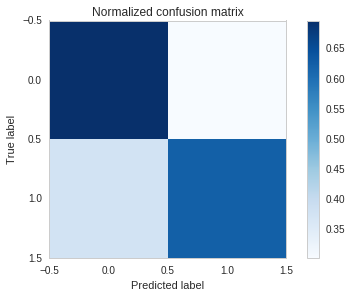

In [26]:
modelpipeline(modeldata,y_input,1)

Performance of Random Forest : 
Accuracy: 0.81 (+/- 0.00)
Precision :  0.540563191418
Recall :  0.223090758163


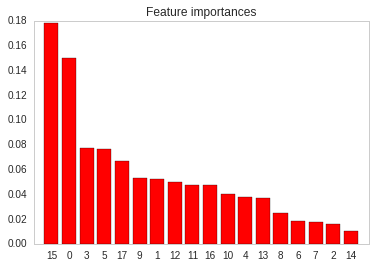

Confusion matrix, without normalization
[[57266  2741]
 [11231  3225]]
Normalized confusion matrix
[[ 0.95  0.05]
 [ 0.78  0.22]]


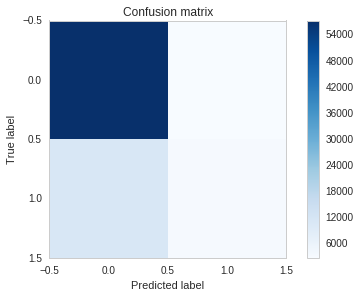

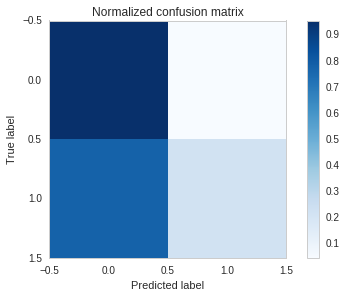

In [27]:
modelpipeline(modeldata,y_input,2)

### Feature Importance :

In [28]:
from sklearn.linear_model import RandomizedLogisticRegression
rlog = RandomizedLogisticRegression()

In [31]:
X_train,X_test,y_train,y_test = train_test_split(modeldata,y_input,test_size=0.33)
rlog.fit(X_train,y_train)

RandomizedLogisticRegression(C=1, fit_intercept=True,
               memory=Memory(cachedir=None), n_jobs=1, n_resampling=200,
               normalize=True, pre_dispatch='3*n_jobs', random_state=None,
               sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
               tol=0.001, verbose=False)

In [32]:
X_train.columns

Index([  u'_STATE',  u'GENHLTH',  u'MEDCOST', u'SLEPTIM1',  u'MARITAL',
        u'EMPLOY1',  u'CPDEMO1',      u'SEX',    u'_RACE',   u'_AGE_G',
       u'_BMI5CAT',  u'_EDUCAG',  u'_INCOMG', u'_SMOKER3', u'_RFDRHV4',
       u'_VEGESUM',  u'_PACAT1',  u'Chronic'],
      dtype='object')

In [33]:
rlog.scores_

array([ 0.01,  1.  ,  1.  ,  0.  ,  0.54,  1.  ,  0.48,  1.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.51,  0.  ,  1.  ,  1.  ])

In [49]:
from sklearn.linear_model import RandomizedLasso

X = modeldata
Y = y_input
names = X.columns 
rlasso = RandomizedLasso(alpha=0.00005)
rlasso.fit(X, Y)
 
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), names), reverse=True)

Features sorted by their score:
[(1.0, u'GENHLTH'), (0.775, u'MEDCOST'), (0.73, 'Chronic'), (0.54, u'_SMOKER3'), (0.515, u'_INCOMG'), (0.495, u'SEX'), (0.26, u'_PACAT1'), (0.245, u'_AGE_G'), (0.145, u'_BMI5CAT'), (0.065, u'EMPLOY1'), (0.0, u'_VEGESUM'), (0.0, u'_STATE'), (0.0, u'_RFDRHV4'), (0.0, u'_RACE'), (0.0, u'_EDUCAG'), (0.0, u'SLEPTIM1'), (0.0, u'MARITAL'), (0.0, u'CPDEMO1')]


In [66]:
# Based on feature scores of randomized logistic regression + randomized lasso - remove the following features
modeldata.drop(['_STATE','SLEPTIM1','MARITAL','CPDEMO1','_RFDRHV4','_VEGESUM','_RACE','_EDUCAG'],inplace=True,axis=1)

Performance of Logistic Regression : 
Accuracy: 0.68 (+/- 0.01)
Precision :  0.329392877992
Recall :  0.63115212528
Confusion matrix, without normalization
[[41779 18380]
 [ 5276  9028]]
Normalized confusion matrix
[[ 0.69  0.31]
 [ 0.37  0.63]]


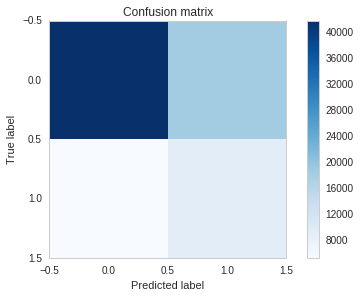

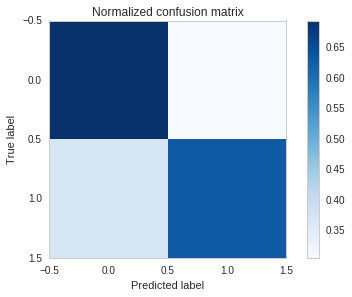

In [68]:
modelpipeline(modeldata,y_input,1)

In [52]:
X_train,X_test,y_train,y_test = train_test_split(modeldata,y_input,test_size=0.33)
rlog.fit(X_train,y_train)

RandomizedLogisticRegression(C=1, fit_intercept=True,
               memory=Memory(cachedir=None), n_jobs=1, n_resampling=200,
               normalize=True, pre_dispatch='3*n_jobs', random_state=None,
               sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
               tol=0.001, verbose=False)

In [55]:
rlog.scores_

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [83]:
X = modeldata
Y = y_input
names = X.columns 
rlasso = RandomizedLasso(alpha=0.00005)
rlasso.fit(X, Y)
 
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), names), reverse=True)

Features sorted by their score:
[(1.0, u'GENHLTH'), (0.79, u'MEDCOST'), (0.79, 'Chronic'), (0.55, u'_INCOMG'), (0.545, u'SEX'), (0.505, u'_SMOKER3'), (0.3, u'_AGE_G'), (0.26, u'_PACAT1'), (0.14, u'_BMI5CAT'), (0.065, u'EMPLOY1')]


In [127]:
tickname = []
i = 0
for each in indices:
    tickname.append(aa[each])
    i = i + 1

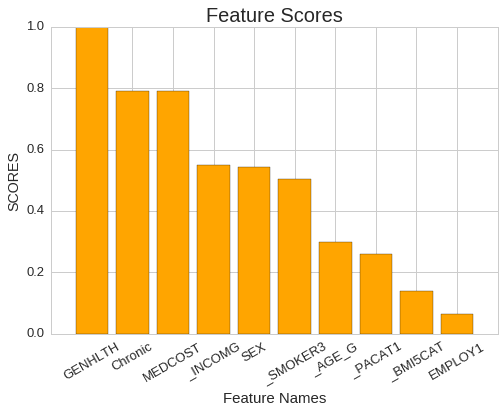

In [138]:
importances = rlasso.scores_
indices = np.argsort(importances)[::-1]
# Plot the feature importances 
sns.set_style("whitegrid", {'axes.grid' : True})
plt.figure()
plt.title("Feature Scores",fontsize = 20)
plt.xlabel('Feature Names',fontsize = 15)
plt.ylabel('SCORES')
plt.bar(range(X_train.shape[1]), rlasso.scores_[indices],color="orange",align="center", edgecolor='black')
plt.xticks(range(X_train.shape[1]), tickname, rotation = 30)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### ROC Curve for Logistic Regression Model:

In [74]:
from sklearn.metrics import roc_curve, auc

X_train,X_test,y_train,y_test = train_test_split(modeldata,y_input,test_size=0.33)
logregr.fit(X_train,y_train)
scores = logregr.predict_proba(X_test)

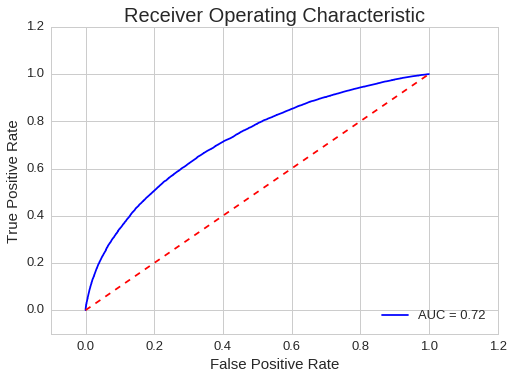

In [139]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,scores[:,1] )
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic',fontsize = 20)
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate',fontsize = 15)
plt.xlabel('False Positive Rate',fontsize = 15)
plt.show()

<hr style="height:1px">
<hr style="height:1px">